In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = os.path.abspath(".") 
if project_root not in sys.path:
    sys.path.append(project_root)
print(sys.path[-1])


/Users/dannyhuang/Developer/gflownet2/base


In [2]:
import numpy as np   
import argparse
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

from disc_gflownet.utils.setting import set_seed, set_device, tf
from disc_gflownet.utils.plotting import plot_loss_curve
from disc_gflownet.agents.tbflownet_agent import TBFlowNetAgent
from disc_gflownet.agents.dbflownet_agent import DBFlowNetAgent
from disc_gflownet.envs.grid_env import GridEnv
from disc_gflownet.envs.set_env import SetEnv

from reward_func.evo_devo import oscillator_reward_func, somitogenesis_reward_func

# reward function 

In [3]:
# Define a custom reward function
def coord_reward_func(state):
    reward1 = sum(1 for coord in state if coord == 3) + 0.001 # args.min_reward
    reward2 = sum(1 for coord in state if coord == 5) + 0.002 # args.min_reward
    return reward1 + reward2


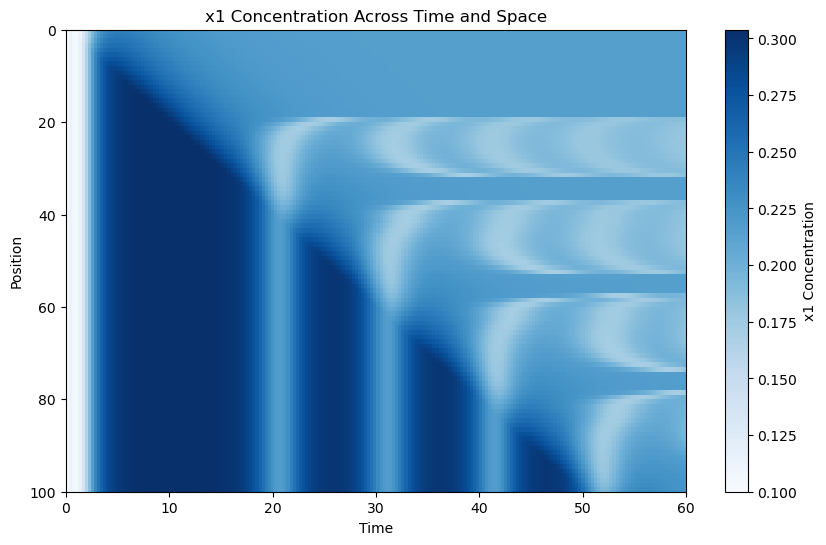

x1 concentration at last time step:
[0.21505699 0.21505705 0.21505712 0.21505719 0.21505727 0.21505736
 0.21505746 0.21505757 0.21505769 0.21505782 0.21505797 0.21505813
 0.21505831 0.21505851 0.21505873 0.21505897 0.21505924 0.21505953
 0.21505986 0.1856919  0.18188176 0.18086645 0.18067152 0.18059592
 0.18047374 0.18030759 0.18020085 0.18038062 0.1812805  0.183624
 0.18772965 0.18478029 0.21507031 0.21507181 0.21507343 0.21507522
 0.21507714 0.18899584 0.18577248 0.18269689 0.18181242 0.18153382
 0.18095138 0.18030115 0.17986188 0.17969436 0.17985298 0.18045137
 0.18173747 0.18404044 0.18757795 0.19153125 0.1889835  0.21502389
 0.21518035 0.21519415 0.21520817 0.19253475 0.19219906 0.19036873
 0.18686543 0.18563262 0.18537221 0.18468665 0.18380574 0.1832798
 0.183401   0.1842945  0.18608042 0.18888196 0.19264979 0.1966471
 0.19772417 0.179802   0.21557737 0.2159951  0.21611371 0.21614174
 0.17216967 0.19956795 0.19842985 0.19567201 0.19518537 0.19503664
 0.19425325 0.19341681 0.19318

In [4]:

test_weights = [-60, -150, 0, -109, 65, -66, -145, 41, 58] # -41(41), 58
reward = somitogenesis_reward_func(test_weights, plot=True)
print(f"Reward for somitogenesis: {reward}")


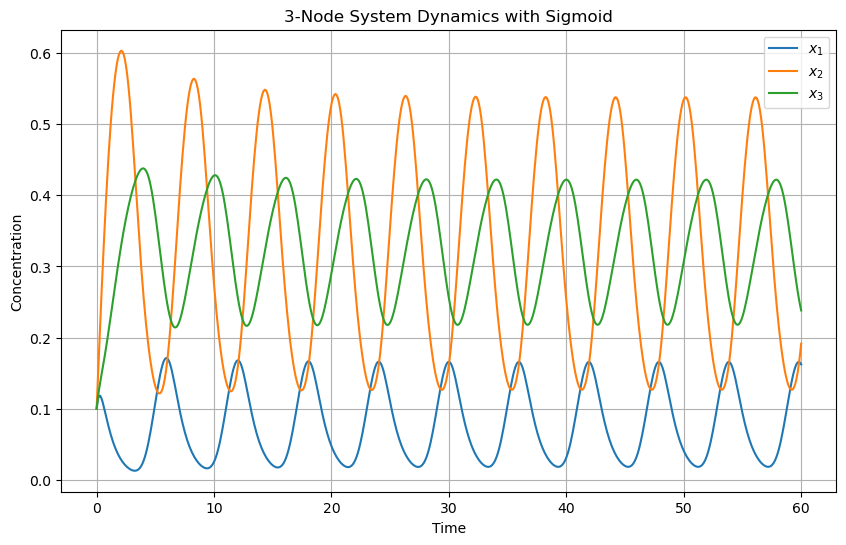

Reward for oscillator: 10


In [20]:
# test_weights = [-5, 2, 3, 1, 2, -1, 2, 1, -3] 
test_weights = [0, -10, 0, 4, 6, -10, -10, 0, 0]  # w12=-5, w22=..., w23=-10, w31=-10
reward = oscillator_reward_func(test_weights, plot=True)
print(f"Reward for oscillator: {reward}")

# Grid GFN 

In [96]:


def main(args):
    global all_losses  
    global logZs
    global agent

    assert args.envsize == args.mbsize
    set_seed(args.seed)
    set_device(torch.device(args.device))
    method_name = args.method
    
    envs = [GridEnv(args) for _ in range(args.envsize)]
    if args.method == 'tb_gfn':
        agent = TBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}, {'params':[agent.Z], 'lr': args.tb_z_lr} ])
    elif args.method == 'db_gfn' or args.method == 'fldb_gfn':
        agent = DBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}])


    
    """train"""
    
    all_losses = [] 
    logZs = []  # only for tb_gfn
    for i in tqdm(range(args.n_train_steps + 1), disable=not args.progress):
        experiences = agent.sample_batch_episodes(args.mbsize)
        if method_name == 'fldb_gfn':
            losses = agent.compute_batch_loss(experiences, use_fldb=True) 
        else:
            losses = agent.compute_batch_loss(experiences) 
            
        all_losses.append(losses[0].item())
        logZs.append(losses[1].item()) 

        losses[0].backward()
        opt.step()
        opt.zero_grad() 
        
        if i % args.log_freq == 0 and args.log_flag:
            print("\n")
            print("-"*10)
            print("Step: ", i)
            print("Number of unique states found: ", len(agent.ep_last_state_counts))
            print("Top 12 states by terminal reward:")
            top_states = sorted(agent.ep_last_state_ep_rewards.items(), 
                              key=lambda x: x[1][-1], # Sort by last reward in trajectory
                              reverse=True)[:12]
            for state in top_states:
                ep_rewards = [f"{r[0]:.3f}" for r in agent.ep_last_state_ep_rewards[state[0]]]
                count = agent.ep_last_state_counts[state[0]]
                print(f"Full trajectory rewards: {ep_rewards}, Count: {count}, State: {state[0]}")
            print("\n")


In [ ]:
print("num of threads in use by default: ", torch.get_num_threads())
# torch.set_num_threads(1)



# Set up argparse arguments manually
args = argparse.Namespace(
    device='cpu',
    progress=True,
    seed=0,
    n_train_steps=1000,  # 2000
    log_freq=10,  # 1000
    log_flag=True,
    mbsize=16,
    # Model
    method='tb_gfn', 
    learning_rate=1e-4,
    tb_lr=0.001,
    tb_z_lr=0.1,
    n_hid=256,
    n_layers=3,
    explore_ratio=0.0,  # 0.0625
    temp=1.,
    uni_rand_pb=1,
    # Env
    envsize=16,
    min_reward=0.1,
    custom_reward_fn=oscillator_reward_func,
    n_steps=50,  
    n_dims=9,  
    actions_per_dim=[-1, -5], # if inhomogenous, need to be a closed symmetrical group.
    grid_bound=10
)

# Call the main function
main(args)



In [ ]:
title = "Loss and Z for the ({}) Model".format(args.method)
plot_loss_curve(all_losses, logZs=logZs, title=title)
print("The final Z (partition function) estimate is {:.2f}".format(np.exp(logZs[-1])))

# print(agent.state_counts)
# print(agent.state_returns)

In [ ]:
print("\n")
print("-"*10) 
# print("Step: ", i)
print("Number of unique states found: ", len(agent.ep_last_state_counts))
print("Top 12 states by visit count:")
top_states = sorted(agent.ep_last_state_counts.items(),
                    key=lambda x: x[1], # Sort by count
                    reverse=True)[:12]
for state, count in top_states:
    ep_rewards = [f"{r[0]:.3f}" for r in agent.ep_last_state_ep_rewards[state]]
    print(f"Count: {count}, State: {state}, Full trajectory rewards: {ep_rewards}")
print("\n")


# Testing

In [ ]:
"""masking"""

# Test cases for GridEnv with different action types

# Test case 1: All positive actions
# args_pos = argparse.Namespace(
#     min_reward=0.001,
#     custom_reward_fn=custom_reward_func,
#     n_steps=7,
#     n_dims=2,
#     actions_per_dim=[1, 2],  # Only positive actions
#     grid_bound=5
# )
# env_pos = GridEnv(args_pos)
# env_pos.print_actions()
# env_pos.reset()

# for i in range(5):
#     obs, reward, done = env_pos.step(0)  # Take step with +1 in dim0
#     print(env_pos._state)
#     print(env_pos.get_forward_mask(env_pos._state))
#     print("step: ", env_pos._step)
#     print("done: ", done)
#     print()  # Add blank line between iterations




# # Test case 2: All negative actions  
# args_neg = argparse.Namespace(
#     min_reward=0.001,
#     custom_reward_fn=custom_reward_func,
#     n_steps=17,
#     n_dims=2, 
#     actions_per_dim=[-1, -2],  # Only negative actions
#     grid_bound=5
# )
# env_neg = GridEnv(args_neg)
# env_neg.print_actions()
# env_neg.reset()
# for i in range(5):
#     obs, reward, done = env_neg.step(0)  # Take step with +1 in dim0
#     print(env_neg._state)
#     print("forward: ", env_neg.get_forward_mask(env_neg._state))
#     print("backward: ", env_neg.get_backward_mask(env_neg._state))
#     print("step: ", env_neg._step)
#     print("done: ", done)
#     print()  # Add blank line between iterations
# for i in range(5):
#     obs, reward, done = env_neg.step(2)  # Take step with +1 in dim0
#     print(env_neg._state)
#     print("forward: ", env_neg.get_forward_mask(env_neg._state))
#     print("backward: ", env_neg.get_backward_mask(env_neg._state))
#     print("step: ", env_neg._step)
#     print("done: ", done)
#     print()  # Add blank line between iterations



# # Test case 3: Mixed positive/negative actions
# args_mixed = argparse.Namespace(
#     min_reward=0.001,
#     custom_reward_fn=custom_reward_func,
#     n_steps=17,
#     n_dims=2,
#     actions_per_dim=[1, -1, 2, -2],  # Mixed positive and negative actions
#     grid_bound=5
# )
# env_mixed = GridEnv(args_mixed)
# env_mixed.print_actions()
# env_mixed.reset()

# mixed_test_state = [-5, -5]
# print("forward: ", env_mixed.get_forward_mask(mixed_test_state))
# print("backward: ", env_mixed.get_backward_mask(mixed_test_state))
# print("step: ", env_mixed._step)
# print("done: ", done)
# print()  # Add blank line between iterations



In [62]:

# test_state = [-3, -1]
# print(env_neg.get_forward_mask(test_state))
# print(env_neg.get_backward_mask(test_state))

In [ ]:
"""encoding"""
# print(env_mixed.encoding_dim)
# env_mixed.state_to_encoding([0, 0])

# """Test encoding for negative actions case"""
# args_neg = argparse.Namespace(
#     min_reward=0.001,
#     custom_reward_fn=lambda x: 1.0,  # Simple reward function for testing
#     n_steps=10,
#     n_dims=2,
#     actions_per_dim=[-1, -2],  # Only negative actions
#     grid_bound=5
# )
# env_neg = GridEnv(args_neg)

# # Test encoding for negative actions
# test_states = [
#     [0, 0],      # Origin
#     [-1, -1],    # Lower bounds
#     [-5, -5],    # Intermediate values
#     [-1, -4]     # Mixed negative values
# ]

# print("Testing negative-only action encodings:")
# print("-" * 50)
# for state in test_states:
#     print(f"\nOriginal state: {state}")
#     encoding = env_neg.state_to_encoding(state)
#     decoded = env_neg.encoding_to_state(encoding)
#     print(f"Encoding: {encoding}")
#     print(f"Decoded state: {decoded}")
#     print(f"Encoding matches: {np.array_equal(state, decoded)}")

# # Verify encoding dimension
# print("\nEncoding dimension check:")
# print(f"Expected dimension: {env_neg.encoding_dim}")
# print(f"Actual encoding length: {len(env_neg.state_to_encoding(test_states[0]))}")


In [ ]:
"""step function """

# args_mixed = argparse.Namespace(
#     min_reward=0.001,
#     custom_reward_fn=lambda x: 1.0,  # Simple reward function for testing
#     n_steps=10,
#     n_dims=2,
#     actions_per_dim=[-2, -1, 1, 2],  # Mixed positive and negative actions
#     grid_bound=5
# )
# env_mixed = GridEnv(args_mixed)
# env_mixed.print_actions()

# # Test different step scenarios
# print("Testing step function with mixed actions:")
# print("-" * 50)

# # Test case 1: Starting from origin
# env_mixed.reset()
# print("\nTest Case 1: Starting from origin")
# print(f"Initial state: {env_mixed._state}")
# action = 0  # First action (-2 in first dimension)
# obs, reward, done = env_mixed.step(action)
# print(f"After action {action} (-2 in dim 0):")
# print(f"New state: {env_mixed._state}")
# print(f"Reward: {reward}")
# print(f"Done: {done}")

# # Test case 2: Multiple steps with mixed positive/negative actions
# env_mixed.reset()
# print("\nTest Case 2: Multiple steps")
# print(f"Initial state: {env_mixed._state}")
# actions = [0, 6, 3]  # Mix of positive and negative actions in different dimensions
# for i, action in enumerate(actions):
#     obs, reward, done = env_mixed.step(action)
#     print(f"\nStep {i+1}, Action {action}:")
#     print(f"State: {env_mixed._state}")
#     print(f"Reward: {reward}")
#     print(f"Done: {done}")

# # Test case 3: Step until done
# env_mixed.reset()
# print("\nTest Case 3: Step until done")
# print(f"Initial state: {env_mixed._state}")
# step_count = 0
# while True:
#     # Get valid actions
#     forward_mask = env_mixed.get_forward_mask(env_mixed._state)
#     if not np.any(forward_mask):
#         print("\nNo valid actions left!")
#         break
    
#     # Take first valid action
#     action = np.where(forward_mask)[0][0]
#     obs, reward, done = env_mixed.step(action)
#     step_count += 1
    
#     print(f"\nStep {step_count}, Action {action}:")
#     print(f"State: {env_mixed._state}")
#     print(f"Reward: {reward}")
#     print(f"Done: {done}")
    
#     if done:
#         print("\nEpisode finished!")
#         break
